My very first project with supervised deep learning. I have been reading "Deep Learning with Python" by françois chollet. I am not finished with it, but I really wanted to create my own solution on a given data set. 

The dataset I will be using is https://www.kaggle.com/sonalidasgupta95/churn-prediction-of-bank-customers/downloads/churn-prediction-of-bank-customers.zip/1
It will be a binary classification problem to determine if a customer will exit the bank.

In [1]:
import pandas as pd

data = pd.read_csv('Churn_Modelling.csv')

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Just looking at the data, I will parseout columns 0, 1, 2: Row Number, CustomerId, Surname as these features should have no impact on the prediction of someone exiting the bank. Thus, I am going to use CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, and EstimatedSalary to determine whether the customer will exit. Also, I will preprocess the data that are inconvienient for the network
    - Geography: France will be 0, Spain will be 1, and Germany will be 2
    - Gender: Female will be 0, Male will be 1
    - Balance: Get the mean then divide by the standard deviation
    - EstimatedSalary: Get the mean then divide by the standard deviation

In [2]:
import csv
import numpy as np

# Getting Data
with open('Churn_Modelling.csv', 'r') as f:
    data = list(csv.reader(f, delimiter=';'))

for i in range(len(data)):
    data[i] = data[i][0].split(',')
    
    # Switching gender to numeric
    if data[i][5] == "Female":
        data[i][5] = 0
    elif data[i][5] == "Male":
        data[i][5] = 1
    
    # Switching geography to numeric
    if data[i][4] == "France":
        data[i][4] = 0
    elif data[i][4] == "Spain":
        data[i][4] = 1
    elif data[i][4] == "Germany":
        data[i][4] = 2
    
    data[i].pop(2)
    data[i].pop(1)
    data[i].pop(0)
    
    if i != 0:
        for j in range(len(data[i])):
            data[i][j] = float(data[i][j])
            
print(data[0])
data.pop(0)
data = np.array(data, np.float64)
print(data[0])

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
[6.1900000e+02 0.0000000e+00 0.0000000e+00 4.2000000e+01 2.0000000e+00
 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0134888e+05
 1.0000000e+00]


Above shows you an example of data formatted in which order. With the data dissected, I am going to cut the data into a training data and testing data. 75% of the data will be used for training and the rest for testing. I will also create a target array for training and testing.

In [3]:
import math

# Splitting the data into train and test
np.random.shuffle(data)

# 75% of the data will be training data
numTrain = math.floor(len(data) * .8)

trainData = data[:numTrain]
testData = data[numTrain:]

trainTarget = []
testTarget = []

for i in range(len(trainData)):
    trainTarget.append(trainData[i][10])
for i in range(len(testData)):
    testTarget.append(testData[i][10])
    
trainData = np.delete(trainData, 10, 1)
testData = np.delete(testData, 10, 1)

Having split up the data, it is ready for it's final data preprocessig. Data features: CreditScore, Balance, and Salary are normalized. By subtracting the feature's mean off it's own and dividing it by the standard deviation, I can make the range of the data smaller. This is so that the network does not encounter wide extreme numbers on input.

In [4]:
# Normalization
credit = []
salary = []
balance = []

for i in range(len(trainData)):
    credit.append(trainData[i][0])
    balance.append(trainData[i][5])
    salary.append(trainData[i][9])

creditMean = np.mean(credit)
salaryMean = np.mean(salary)
balanceMean = np.mean(balance)
creditStd = np.std(credit)
salaryStd = np.std(salary)
balanceStd = np.std(balance)

trainData[:, 0] -= creditMean
trainData[:, 0] /= creditStd
trainData[:, 5] -= balanceMean
trainData[:, 5] /= balanceStd
trainData[:, 9] -= salaryMean
trainData[:, 9] /= salaryStd

testData[:, 0] -= creditMean
testData[:, 0] /= creditStd
testData[:, 5] -= balanceMean
testData[:, 5] /= balanceStd
testData[:, 9] -= salaryMean
testData[:, 9] /= salaryStd

numVal = math.floor(len(trainData) * .10)
valData = trainData[:numVal]
valTarget = trainTarget[:numVal]
trainData = trainData[numVal:]
trainTarget = trainTarget[numVal:]

print(trainData[0])
print(testData[0])


[-0.38657167  0.          1.         40.          4.         -1.22622699
  1.          0.          0.          0.89243784]
[ 0.59997706  2.          1.         45.          4.          0.74275906
  1.          1.          1.         -1.73830093]


Above shows how the range of the features have drastically decreased. Credit score, salary, and balance are now all normalized and ready to be inputted into our model. 
The network model has 4 layers:
    Input Layer : size of 10,
    Hidden Layer 1 : size of 64,
    Hidden LAyer 2 : size of 64,
    Output LAyer : size of 1.
    
As for the compilers, I am testing them.

In [14]:
import keras
from keras import models
from keras import layers
from keras import optimizers

keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 200
model_hist = model.fit(trainData, trainTarget, epochs=300, batch_size=128, validation_data=(valData, valTarget))

Train on 7200 samples, validate on 800 samples
Epoch 1/300
7200/7200 [==============================] - 0s 47us/step - loss: 0.5885 - acc: 0.7851 - val_loss: 0.5454 - val_acc: 0.7850
Epoch 2/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.5101 - acc: 0.7997 - val_loss: 0.5039 - val_acc: 0.7850
Epoch 3/300
7200/7200 [==============================] - 0s 13us/step - loss: 0.4912 - acc: 0.7997 - val_loss: 0.4864 - val_acc: 0.7850
Epoch 4/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.4656 - acc: 0.8022 - val_loss: 0.4600 - val_acc: 0.8125
Epoch 5/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.4666 - acc: 0.8078 - val_loss: 0.4420 - val_acc: 0.8075
Epoch 6/300
7200/7200 [==============================] - 0s 13us/step - loss: 0.4470 - acc: 0.8107 - val_loss: 0.4350 - val_acc: 0.8037
Epoch 7/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.4476 - acc: 0.8143 - val_loss: 0.4313 - val_acc: 0.8087
E

7200/7200 [==============================] - 0s 13us/step - loss: 0.3904 - acc: 0.8356 - val_loss: 0.4147 - val_acc: 0.8237
Epoch 61/300
7200/7200 [==============================] - 0s 13us/step - loss: 0.3915 - acc: 0.8326 - val_loss: 0.3973 - val_acc: 0.8237
Epoch 62/300
7200/7200 [==============================] - 0s 11us/step - loss: 0.3870 - acc: 0.8365 - val_loss: 0.4082 - val_acc: 0.8287
Epoch 63/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3869 - acc: 0.8368 - val_loss: 0.3997 - val_acc: 0.8275
Epoch 64/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3851 - acc: 0.8365 - val_loss: 0.4047 - val_acc: 0.8287
Epoch 65/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3835 - acc: 0.8375 - val_loss: 0.3959 - val_acc: 0.8325
Epoch 66/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3854 - acc: 0.8381 - val_loss: 0.3978 - val_acc: 0.8300
Epoch 67/300
7200/7200 [==============================

Epoch 120/300
7200/7200 [==============================] - 0s 18us/step - loss: 0.3516 - acc: 0.8518 - val_loss: 0.3640 - val_acc: 0.8488
Epoch 121/300
7200/7200 [==============================] - 0s 17us/step - loss: 0.3465 - acc: 0.8556 - val_loss: 0.3700 - val_acc: 0.8488
Epoch 122/300
7200/7200 [==============================] - 0s 17us/step - loss: 0.3456 - acc: 0.8571 - val_loss: 0.3618 - val_acc: 0.8525
Epoch 123/300
7200/7200 [==============================] - 0s 17us/step - loss: 0.3487 - acc: 0.8553 - val_loss: 0.3610 - val_acc: 0.8512
Epoch 124/300
7200/7200 [==============================] - 0s 17us/step - loss: 0.3460 - acc: 0.8568 - val_loss: 0.3604 - val_acc: 0.8475
Epoch 125/300
7200/7200 [==============================] - 0s 18us/step - loss: 0.3495 - acc: 0.8524 - val_loss: 0.3667 - val_acc: 0.8425
Epoch 126/300
7200/7200 [==============================] - 0s 17us/step - loss: 0.3483 - acc: 0.8529 - val_loss: 0.3627 - val_acc: 0.8488
Epoch 127/300
7200/7200 [=========

7200/7200 [==============================] - 0s 14us/step - loss: 0.3334 - acc: 0.8589 - val_loss: 0.3513 - val_acc: 0.8600
Epoch 180/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3359 - acc: 0.8586 - val_loss: 0.3480 - val_acc: 0.8625
Epoch 181/300
7200/7200 [==============================] - 0s 11us/step - loss: 0.3322 - acc: 0.8615 - val_loss: 0.3520 - val_acc: 0.8550
Epoch 182/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3337 - acc: 0.8606 - val_loss: 0.3578 - val_acc: 0.8600
Epoch 183/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3335 - acc: 0.8592 - val_loss: 0.3597 - val_acc: 0.8438
Epoch 184/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3323 - acc: 0.8621 - val_loss: 0.3581 - val_acc: 0.8525
Epoch 185/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3361 - acc: 0.8596 - val_loss: 0.3558 - val_acc: 0.8462
Epoch 186/300
7200/7200 [=======================

7200/7200 [==============================] - 0s 15us/step - loss: 0.3214 - acc: 0.8667 - val_loss: 0.3555 - val_acc: 0.8588
Epoch 239/300
7200/7200 [==============================] - 0s 13us/step - loss: 0.3225 - acc: 0.8651 - val_loss: 0.3505 - val_acc: 0.8625
Epoch 240/300
7200/7200 [==============================] - 0s 13us/step - loss: 0.3215 - acc: 0.8663 - val_loss: 0.3505 - val_acc: 0.8625
Epoch 241/300
7200/7200 [==============================] - 0s 14us/step - loss: 0.3191 - acc: 0.8703 - val_loss: 0.3637 - val_acc: 0.8600
Epoch 242/300
7200/7200 [==============================] - 0s 14us/step - loss: 0.3236 - acc: 0.8656 - val_loss: 0.3709 - val_acc: 0.8575
Epoch 243/300
7200/7200 [==============================] - 0s 12us/step - loss: 0.3225 - acc: 0.8665 - val_loss: 0.3499 - val_acc: 0.8600
Epoch 244/300
7200/7200 [==============================] - 0s 14us/step - loss: 0.3221 - acc: 0.8636 - val_loss: 0.3558 - val_acc: 0.8575
Epoch 245/300
7200/7200 [=======================

7200/7200 [==============================] - 0s 17us/step - loss: 0.3083 - acc: 0.8686 - val_loss: 0.3588 - val_acc: 0.8550
Epoch 298/300
7200/7200 [==============================] - 0s 14us/step - loss: 0.3043 - acc: 0.8721 - val_loss: 0.3631 - val_acc: 0.8575
Epoch 299/300
7200/7200 [==============================] - 0s 14us/step - loss: 0.3069 - acc: 0.8722 - val_loss: 0.3545 - val_acc: 0.8638
Epoch 300/300
7200/7200 [==============================] - 0s 15us/step - loss: 0.3066 - acc: 0.8714 - val_loss: 0.3595 - val_acc: 0.8575


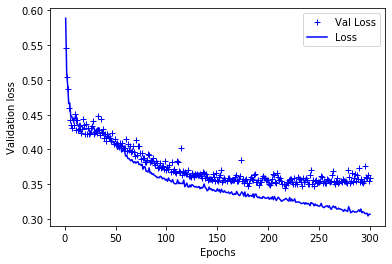

In [15]:
import matplotlib.pyplot as plt

model_acc = model_hist.history['acc']
model_loss = model_hist.history['loss']
model_val_acc = model_hist.history['val_acc']
model_val_loss = model_hist.history['val_loss']

epochs = range(1, len(model_acc) + 1)
# b+ is for "blue cross"
plt.plot(epochs, model_val_loss, 'b+', label='Val Loss')
plt.plot(epochs, model_loss, 'b', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

To combat overfitting, I have plotted the loss for both validation data set and training data set for over 300 epochs. From the graph, I can vaguely tell that the model is starting to overfit at 150 epochs. At 150 epochs, the loss score is stagnant for valdation data; while the loss score for the training data set keeps decreasing. Thus, I'll retrain the model upto 150 epochs.

In [16]:
keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 150
model_hist = model.fit(trainData, trainTarget, epochs=150, batch_size=128, validation_data=(testData, testTarget))

Train on 7200 samples, validate on 2000 samples
Epoch 1/150
7200/7200 [==============================] - 0s 54us/step - loss: 0.5225 - acc: 0.7954 - val_loss: 0.5073 - val_acc: 0.7870
Epoch 2/150
7200/7200 [==============================] - 0s 13us/step - loss: 0.4833 - acc: 0.8015 - val_loss: 0.5183 - val_acc: 0.7680
Epoch 3/150
7200/7200 [==============================] - 0s 13us/step - loss: 0.4765 - acc: 0.7985 - val_loss: 0.4708 - val_acc: 0.7935
Epoch 4/150
7200/7200 [==============================] - 0s 14us/step - loss: 0.4529 - acc: 0.8081 - val_loss: 0.4733 - val_acc: 0.7910
Epoch 5/150
7200/7200 [==============================] - 0s 14us/step - loss: 0.4479 - acc: 0.8117 - val_loss: 0.4690 - val_acc: 0.7970
Epoch 6/150
7200/7200 [==============================] - 0s 13us/step - loss: 0.4445 - acc: 0.8143 - val_loss: 0.4721 - val_acc: 0.7885
Epoch 7/150
7200/7200 [==============================] - 0s 13us/step - loss: 0.4425 - acc: 0.8163 - val_loss: 0.4614 - val_acc: 0.7940


7200/7200 [==============================] - 0s 12us/step - loss: 0.3773 - acc: 0.8403 - val_loss: 0.3738 - val_acc: 0.8395
Epoch 61/150
7200/7200 [==============================] - 0s 12us/step - loss: 0.3698 - acc: 0.8440 - val_loss: 0.3778 - val_acc: 0.8335
Epoch 62/150
7200/7200 [==============================] - 0s 12us/step - loss: 0.3678 - acc: 0.8458 - val_loss: 0.3722 - val_acc: 0.8365
Epoch 63/150
7200/7200 [==============================] - 0s 12us/step - loss: 0.3726 - acc: 0.8426 - val_loss: 0.3850 - val_acc: 0.8280
Epoch 64/150
7200/7200 [==============================] - 0s 12us/step - loss: 0.3714 - acc: 0.8458 - val_loss: 0.3717 - val_acc: 0.8350
Epoch 65/150
7200/7200 [==============================] - 0s 12us/step - loss: 0.3651 - acc: 0.8446 - val_loss: 0.3792 - val_acc: 0.8345
Epoch 66/150
7200/7200 [==============================] - 0s 12us/step - loss: 0.3669 - acc: 0.8482 - val_loss: 0.3701 - val_acc: 0.8395
Epoch 67/150
7200/7200 [==============================

Epoch 120/150
7200/7200 [==============================] - 0s 14us/step - loss: 0.3448 - acc: 0.8575 - val_loss: 0.3660 - val_acc: 0.8410
Epoch 121/150
7200/7200 [==============================] - 0s 13us/step - loss: 0.3469 - acc: 0.8571 - val_loss: 0.3724 - val_acc: 0.8385
Epoch 122/150
7200/7200 [==============================] - 0s 13us/step - loss: 0.3481 - acc: 0.8546 - val_loss: 0.3572 - val_acc: 0.8450
Epoch 123/150
7200/7200 [==============================] - 0s 14us/step - loss: 0.3448 - acc: 0.8572 - val_loss: 0.3702 - val_acc: 0.8390
Epoch 124/150
7200/7200 [==============================] - 0s 14us/step - loss: 0.3470 - acc: 0.8572 - val_loss: 0.3578 - val_acc: 0.8430
Epoch 125/150
7200/7200 [==============================] - 0s 13us/step - loss: 0.3459 - acc: 0.8539 - val_loss: 0.3619 - val_acc: 0.8425
Epoch 126/150
7200/7200 [==============================] - 0s 14us/step - loss: 0.3491 - acc: 0.8539 - val_loss: 0.3554 - val_acc: 0.8440
Epoch 127/150
7200/7200 [=========

I will plot the loss once more.

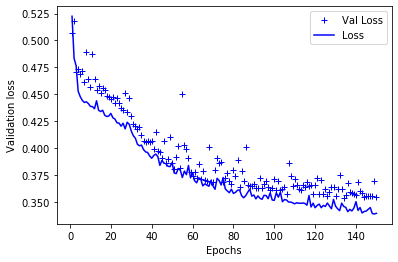

In [17]:
model_acc = model_hist.history['acc']
model_loss = model_hist.history['loss']
model_val_acc = model_hist.history['val_acc']
model_val_loss = model_hist.history['val_loss']

epochs = range(1, len(model_acc) + 1)
# b+ is for "blue cross"
plt.plot(epochs, model_val_loss, 'b+', label='Val Loss')
plt.plot(epochs, model_loss, 'b', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Looks a little better. Now to evaluate with the testing data.

In [18]:
test_loss, test_acc = model.evaluate(testData, testTarget)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

2000/2000 [==============================] - 0s 24us/step
Test Loss:  0.3548030288219452
Test Accuracy:  0.8475
